# Forecasting Exercises
This exercise walks through a SARIMA prediction and forecast similar to the one done on the Mauna Loa CO₂ dataset.<br>
This time we're using a seasonal time series of California Hospitality Industry Employees.

<div class="alert alert-danger" style="margin: 10px"><strong>IMPORTANT NOTE!</strong> Make sure you don't run the cells directly above the example output shown, <br>otherwise you will end up writing over the example output!</div>

In [19]:
# RUN THIS CELL
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('../Data/HospitalityEmployees.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'
print(len(df))
print(df.head())

348
            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


So <tt>df</tt> has 348 records and one column. The data represents the number of employees in thousands of persons as monthly averages from January, 1990 to December 2018.

### 1. Plot the source data
Create a line chart of the dataset. Optional: add a title and y-axis label.

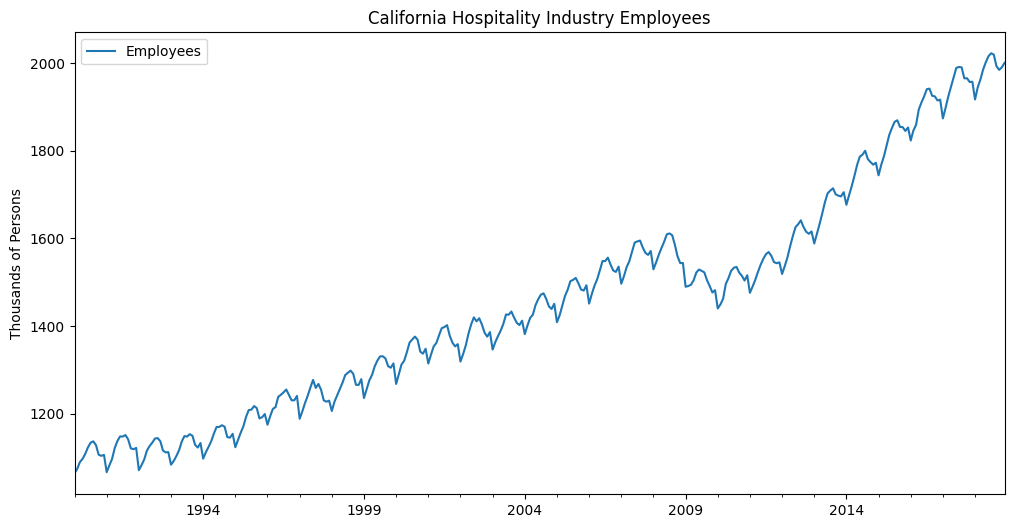

In [2]:
## CODE HERE
title = 'California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = df['Employees'].plot(legend=True,figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

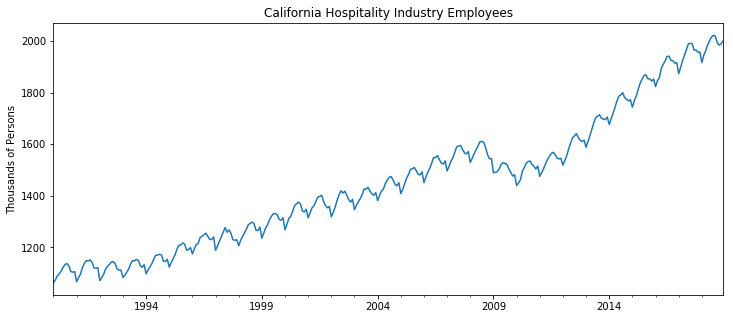

In [2]:
# DON'T WRITE HERE

### 2. Run an ETS Decomposition
Use an 'additive' model.

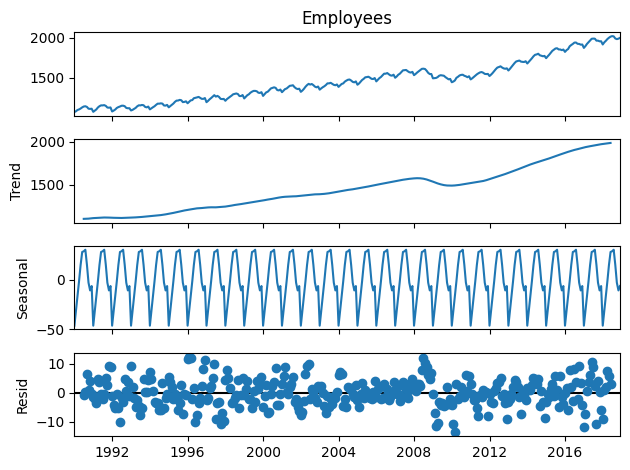

In [3]:
result = seasonal_decompose(df['Employees'], model='add')
result.plot(); 

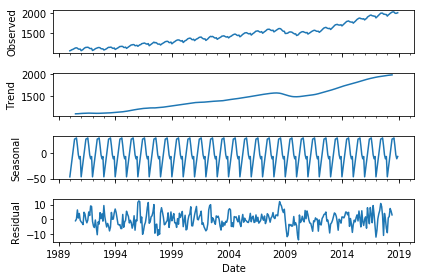

In [3]:
# DON'T WRITE HERE

### 2.1. Run an ADF test

In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [5]:
adf_test(df['Employees'], 'California Hospitality Industry Employees')

Augmented Dickey-Fuller Test: California Hospitality Industry Employees
ADF test statistic        0.901284
p-value                   0.993107
# lags used              17.000000
# observations          330.000000
critical value (1%)      -3.450322
critical value (5%)      -2.870338
critical value (10%)     -2.571458
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### 2.2. Run a KPSS test

In [6]:
from statsmodels.tsa.stattools import kpss

kpss_test = kpss(df['Employees'], regression='c')

statistic, p_value, n_lags, critical_values = kpss_test

print(f'KPSS Statistic: {statistic}')
print(f'P-Value: {p_value}')
print(f'Number of Lags Used: {n_lags}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key} : {value}')

alpha = 0.05
if p_value > alpha:
    print('The null hypothesis cannot be rejected (The series is stationary)')
else:
    print('The null hypothesis can be rejected (The series is not stationary)')

KPSS Statistic: 2.811347117430525
P-Value: 0.01
Number of Lags Used: 11
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The null hypothesis can be rejected (The series is not stationary)


### 2.3. Run a PP (Phillips-Perron) test

In [7]:
from arch.unitroot import PhillipsPerron

pp_test = PhillipsPerron(df['Employees'])

print(pp_test.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                  0.575
P-value                         0.987
Lags                               17
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


$\text{Cannot reject the null hypothesis here}$

### 2.4. Plot ACF and PACF

In [14]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

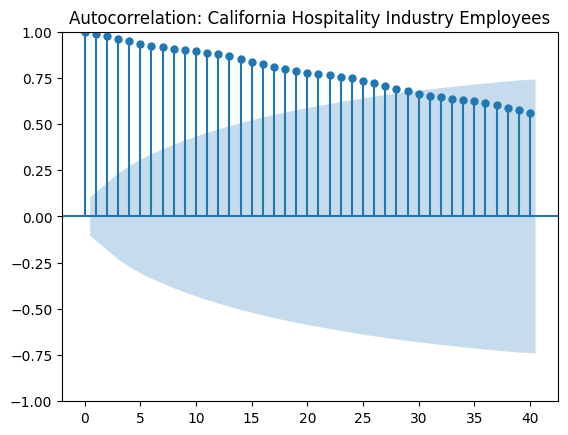

In [15]:
# ACF
title = 'Autocorrelation: California Hospitality Industry Employees'
lags = 40
plot_acf(df,title=title,lags=lags);

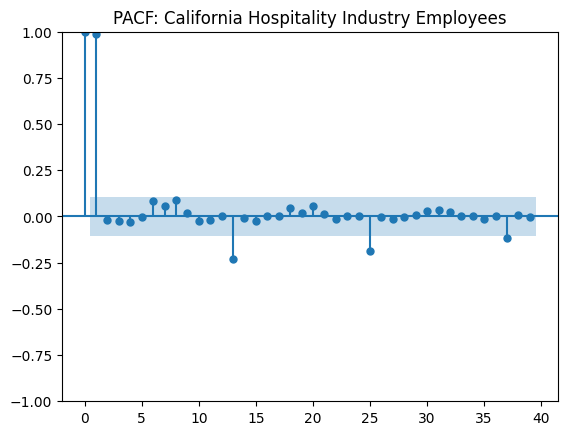

In [16]:
# PACF
title='PACF: California Hospitality Industry Employees'
lags=40
plot_pacf(df.dropna(),title=title,lags=np.arange(lags));

### 3. Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot of combinations to evaluate.

In [9]:
auto_arima(df['Employees'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1098.252
Date:                              Wed, 24 May 2023   AIC                           2208.504
Time:                                      23:00:25   BIC                           2231.600
Sample:                                  01-01-1990   HQIC                          2217.700
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9244      0.045     20.483      0.000       0.836       1.013
ma.L1         -0.9440      0.070    -13.516      0.000      -1.081      -0.807
ma.L2          0.1288      0.060      2.146      0.032       0.011       0.246
ar.S.L12       0.9972      0.001    706.730      0.000       0.994       1.000
ma.S.L12      -0.7490      0.043    -17.307      0.000      -0.834      -0.664
sigma2        29.2997      1.718     17.058      0.000      25.933      32.666
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                67.44
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [4]:
# DON'T WRITE HERE

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  348
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -1134.664
Date:                            Wed, 27 Mar 2019   AIC                           2277.328
Time:                                    13:12:10   BIC                           2292.726
Sample:                                         0   HQIC                          2283.459
                                            - 348                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0477      0.292     -0.163      0.870      -0.620       0.524
ar.S.L12       0.5291      0.040     13.286      0.000       0.451       0.607
ar.S.L24       0.4303      0.041     10.453      0.000       0.350       0.511
sigma2        37.2952      2.157     17.294      0.000      33.068      41.522
===================================================================================
Ljung-Box (Q):                       99.53   Jarque-Bera (JB):                51.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.29
Prob(H) (two-sided):                  0.42   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

You should see a recommended ARIMA Order of (0,1,0) combined with a seasonal order of (2,0,0,12).

### 3.1. Do a stepwise fit

In [17]:
stepwise_fit = auto_arima(df, start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2232.831, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2974.636, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2707.381, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2980.790, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2707.813, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=2233.771, Time=1.82 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=2233.833, Time=1.54 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=2599.941, Time=0.61 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2233.543, Time=0.38 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2233.847, Time=0.60 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : 

### 4. Split the data into train/test sets
Set one year (12 records) for testing. There is more than one way to do this!

In [20]:
len(df)

348

In [21]:
nobs=12
train, test = df[0:-nobs], df[-nobs:]

print(train.shape)
print(test.shape)

(336, 1)
(12, 1)


In [5]:
# DON'T WRITE HERE

### 5. Fit a SARIMA(0,1,0)(2,0,0,12) model to the training set

In [22]:
model = SARIMAX(train['Employees'],order=(1,1,2),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Employees   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1058.058
Date:                              Thu, 25 May 2023   AIC                           2128.116
Time:                                      07:56:42   BIC                           2151.001
Sample:                                  01-01-1990   HQIC                          2137.240
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9242      0.044     21.212      0.000       0.839       1.010
ma.L1         -0.9585      0.069    -13.866      0.000      -1.094      -0.823
ma.L2          0.1498      0.060      2.508      0.012       0.033       0.267
ar.S.L12       0.9973      0.001    723.809      0.000       0.995       1.000
ma.S.L12      -0.7520      0.044    -17.192      0.000      -0.838      -0.666
sigma2        28.7632      1.684     17.079      0.000      25.462      32.064
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.33
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.17
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
# DON'T WRITE HERE

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          Employees   No. Observations:                  336
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -1095.407
Date:                            Wed, 27 Mar 2019   AIC                           2196.814
Time:                                    13:12:24   BIC                           2208.256
Sample:                                01-01-1990   HQIC                          2201.375
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5204      0.040     13.051      0.000       0.442       0.599
ar.S.L24       0.4385      0.041     10.593      0.000       0.357       0.520
sigma2        37.1907      2.165     17.175      0.000      32.947      41.435
===================================================================================
Ljung-Box (Q):                      102.80   Jarque-Bera (JB):                56.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.35
Prob(H) (two-sided):                  0.74   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6. Obtain predicted values

In [23]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,2)(1,0,1,12) Predictions')

In [24]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Employees'][i]}")

predicted=1922.287634, expected=1916.8
predicted=1941.847448, expected=1944.5
predicted=1959.856571, expected=1962.2
predicted=1983.207147, expected=1984.9
predicted=2002.912824, expected=2001.5
predicted=2019.445254, expected=2015.3
predicted=2026.309624, expected=2022.1
predicted=2028.25064 , expected=2019.1
predicted=2009.87027 , expected=1992.5
predicted=2004.776611, expected=1984.3
predicted=1996.723756, expected=1990.1
predicted=2000.526837, expected=2000.2


In [7]:
# DON'T WRITE HERE

### 7. Plot predictions against known values
Optional: add a title and y-axis label.

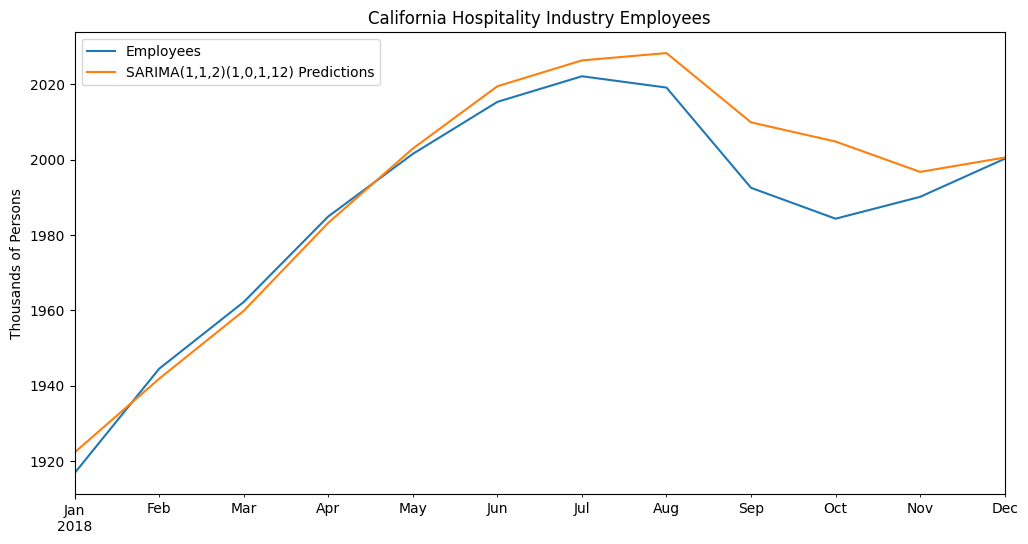

In [25]:
title = 'California Hospitality Industry Employees'
ylabel = 'Thousands of Persons'
xlabel = ''

ax = test['Employees'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

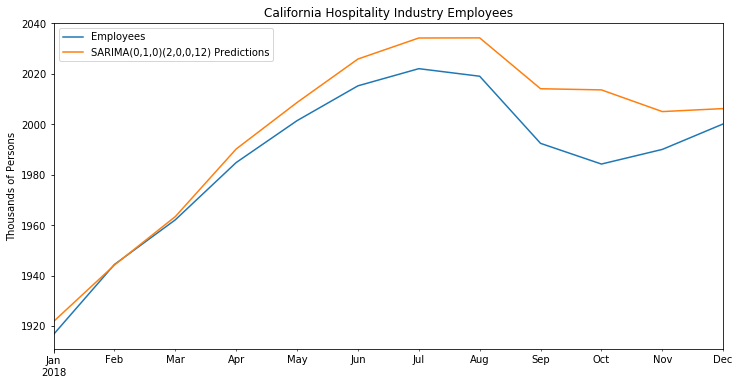

In [8]:
# DON'T WRITE HERE

### 8. Evaluate the Model using MSE and RMSE
You can run both from the same cell if you want.

In [26]:
sarima_mse = mean_squared_error(test['Employees'], predictions)
print(f'SARIMA(1,1,2)(1,0,1,12) MSE Error: {sarima_mse:11.10}')

sarima_rmse = rmse(test['Employees'], predictions)
print(f'SARIMA(1,1,2)(1,0,1,12) RMSE Error: {sarima_rmse:11.10}')

SARIMA(1,1,2)(1,0,1,12) MSE Error: 77.59506275
SARIMA(1,1,2)(1,0,1,12) RMSE Error: 8.808805978


In [9]:
# DON'T WRITE HERE

SARIMA(0,1,0)(2,0,0,12) MSE Error: 182.8506646
SARIMA(0,1,0)(2,0,0,12) RMSE Error: 13.52222854


### 8.1. Evaluate the model using other metrics

(e.g., MAE, MAPE, sMAPE, MFE, MPE, MSLE, RMSLE, MASE, NRMSE, $R^2$, adjusted $R^2$)

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, mean_squared_error, r2_score
from sklearn.metrics._regression import _check_reg_targets
import numpy as np

mae = mean_absolute_error(test['Employees'], predictions)
print(f'MAE Error: {mae:11.10}')

mape = np.mean(np.abs((test['Employees'] - predictions) / test['Employees'])) * 100
print(f'MAPE Error: {mape:11.10}')

smape = 100/len(test['Employees']) * np.sum(2 * np.abs(predictions - test['Employees']) / (np.abs(test['Employees']) + np.abs(predictions)))
print(f'sMAPE Error: {smape:11.10}')

MAE Error: 6.324356925
MAPE Error: 0.3181642703
sMAPE Error: 0.317220883


In [28]:
mfe = np.mean(test['Employees'] - predictions)
print(f'MFE Error: {mfe:11.10}')

mpe = np.mean((test['Employees'] - predictions) / test['Employees']) * 100
print(f'MPE Error: {mpe:11.10}')

MFE Error: -5.209551117
MPE Error: -0.2613095501


In [29]:
msle = mean_squared_log_error(test['Employees'], predictions)
print(f'MSLE Error: {msle:11.10}')

rmsle = np.sqrt(mean_squared_log_error(test['Employees'], predictions))
print(f'RMSLE Error: {rmsle:11.10}')

nrmse = np.sqrt(mean_squared_error(test['Employees'], predictions)) / (np.max(test['Employees']) - np.min(test['Employees']))
print(f'NRMSE Error: {nrmse:11.10}')

MSLE Error: 1.943840889e-05
RMSLE Error: 0.004408901097
NRMSE Error: 0.08365437775


In [30]:
r2 = r2_score(test['Employees'], predictions)
print(f'R^2: {r2:11.10}')

n = len(test['Employees'])  # number of samples
p = 1  # number of predictors (change according to your case)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print(f'Adjusted R^2: {adj_r2:11.10}')

# for MASE and sMape we need the naive forecast (naive forecast is when we predict the next observation to be the same as the current)

naive_forecast = test['Employees'].shift(1).dropna()
mase_num = np.abs(test['Employees'][1:] - predictions[1:])
mase_den = np.abs(test['Employees'][1:] - naive_forecast[1:])
mase = np.mean(mase_num / mase_den)
print(f'MASE Error: {mase:11.10}')

R^2: 0.9140974641
Adjusted R^2: 0.9055072105
MASE Error: 0.8586290769


### 9. Retrain the model on the full data and forecast one year into the future

In [18]:
model = SARIMAX(df['Employees'],order=(1,1,2),seasonal_order=(1,0,1,12))
results = model.fit()

fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(1,1,2)(1,0,1,12) Forecast')

In [10]:
# DON'T WRITE HERE

### 10. Plot the forecasted values alongside the original data
Optional: add a title and y-axis label.

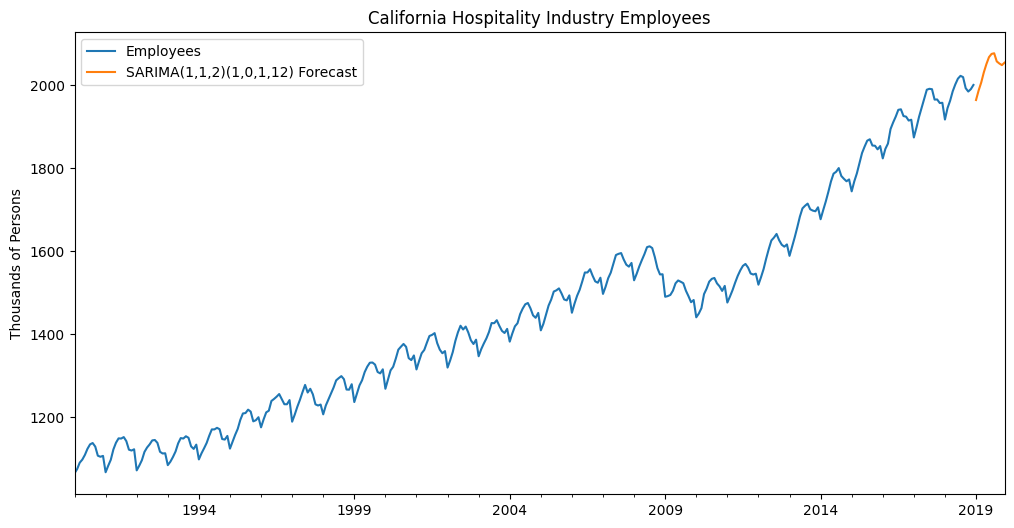

In [19]:
title = 'California Hospitality Industry Employees'
ylabel = 'Thousands of Persons'
xlabel = ''

ax = df['Employees'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

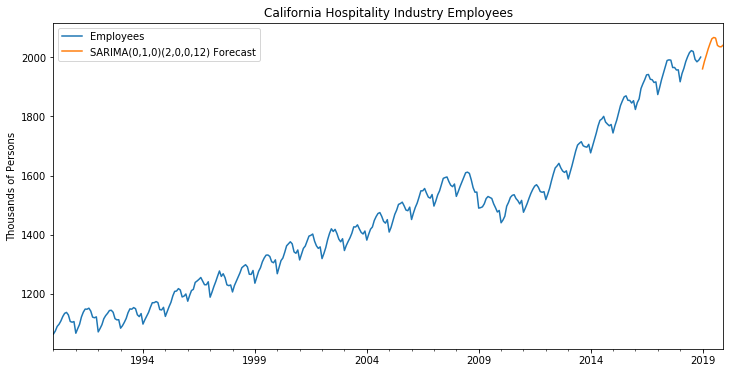

In [11]:
# DON'T WRITE HERE

## Great job!